In [1]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer, StandardScaler, MinMaxScaler

%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
X_train = pd.read_csv('files/x_train.csv', sep=';')
y_train = pd.read_csv('files/y_train.csv', sep=';', header=None)

In [3]:
pipe = make_pipeline(StandardScaler())

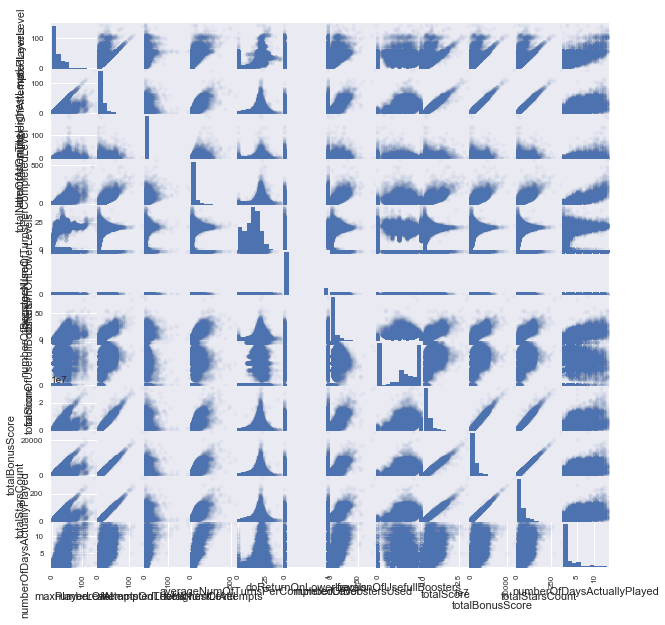

In [4]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(X_train, alpha=0.05, figsize=(10, 10));

In [8]:
X_train.corr()

,maxPlayerLevel,numberOfAttemptedLevels,attemptsOnTheHighestLevel,totalNumOfAttempts,averageNumOfTurnsPerCompletedLevel,doReturnOnLowerLevels,numberOfBoostersUsed,fractionOfUsefullBoosters,totalScore,totalBonusScore,totalStarsCount,numberOfDaysActuallyPlayed
maxPlayerLevel,1.000000,0.616157,0.472142,0.757854,0.683706,0.368297,0.675955,0.126235,0.570234,0.551366,0.579593,0.793385
numberOfAttemptedLevels,0.616157,1.000000,0.300797,0.836398,0.531197,0.290636,0.881915,0.332887,0.979954,0.989014,0.993779,0.663450
attemptsOnTheHighestLevel,0.472142,0.300797,1.000000,0.532032,0.277072,0.197035,0.389465,-0.041700,0.277326,0.264804,0.281343,0.524109
totalNumOfAttempts,0.757854,0.836398,0.532032,1.000000,0.509510,0.391969,0.836706,0.128843,0.798051,0.795570,0.808989,0.846448
averageNumOfTurnsPerCompletedLevel,0.683706,0.531197,0.277072,0.509510,1.000000,0.250261,0.543847,0.457168,0.499681,0.489411,0.514770,0.555594
doReturnOnLowerLevels,0.368297,0.290636,0.197035,0.391969,0.250261,1.000000,0.320439,0.071646,0.310218,0.271397,0.288803,0.383024
numberOfBoostersUsed,0.675955,0.881915,0.389465,0.836706,0.543847,0.320439,1.000000,0.203519,0.854263,0.851824,0.862254,0.751712
fractionOfUsefullBoosters,0.126235,0.332887,-0.041700,0.128843,0.457168,0.071646,0.203519,1.000000,0.328287,0.358474,0.358219,0.058929
totalScore,0.570234,0.979954,0.277326,0.798051,0.499681,0.310218,0.854263,0.328287,1.000000,0.985111,0.986423,0.617847
totalBonusScore,0.551366,0.989014,0.264804,0.795570,0.489411,0.271397,0.851824,0.358474,0.985111,1.000000,0.997357,0.606864


In [ ]:
col1 = 'maxPlayerLevel'
col2 = 'numberOfDaysActuallyPlayed'

plt.figure(figsize=(10, 6))

plt.scatter(X_train[col1][X_train['class'] == '+'],
            X_train[col2][X_train['class'] == '+'],
            alpha=0.75,
            color='red',
            label='+')

plt.scatter(daX_trainta[col1][X_train['class'] == '-'],
            X_train[col2][X_train['class'] == '-'],
            alpha=0.75,
            color='blue',
            label='-')

plt.xlabel(col1)
plt.ylabel(col2)
plt.legend(loc='best');

In [4]:
import xgboost as xgb

xgbclf = xgb.XGBClassifier()
X_train_trans = pipe.fit_transform(X_train)
y_train_trans = y_train[0].values


/Users/ponkin/Development/kaggle/bike_sharing/notebook/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
from sklearn.metrics import log_loss
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import train_test_split

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train_trans, y_train_trans, test_size=0.7, random_state=17)

space = {
        'max_depth': hp.choice('max_depth', np.arange(3, 10, dtype=int)),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.7, 1),
         'n_estimators': hp.choice('x_n_estimators', np.arange(800, 10000, dtype=int)),
         'learning_rate': hp.uniform ('x_learning_rate', 0.001, 0.1)
    }

def objective(space):

    clf = xgb.XGBClassifier(n_estimators = space['n_estimators'],
                            learning_rate=space['learning_rate'],
                            max_depth = space['max_depth'],
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'])

    eval_set  = [( X_train1, y_train1), ( X_test1, y_test1)]

    clf.fit(X_train1, y_train1,
            eval_set=eval_set,
            eval_metric="logloss", 
            early_stopping_rounds=50)

    pred = clf.predict_proba(X_test1)[:,1]
    auc = log_loss(y_test1, pred)
    print("SCORE: %0.7f" % auc)
    return {'loss':auc, 'status': STATUS_OK }


trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

print(best)

In [16]:
print(best)

{'x_subsample': 0.7790196761324767, 'x_n_estimators': 8100, 'x_learning_rate': 0.04050021465231813, 'x_min_child': 8.0, 'max_depth': 0}


In [17]:
xgbclf1 = xgb.XGBClassifier(n_estimators = 8100, nthread=4, learning_rate=0.04050021465231813, min_child_weight=8, max_depth=0, subsample=0.7790196761324767)
xgbclf1.fit(X_train_trans, y_train_trans)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.04050021465231813, max_delta_step=0,
       max_depth=0, min_child_weight=8, missing=None, n_estimators=8100,
       nthread=4, objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7790196761324767)

In [18]:
X_test = pd.read_csv('files/x_test.csv', sep=';')

In [19]:
X_test.head(1)

,maxPlayerLevel,numberOfAttemptedLevels,attemptsOnTheHighestLevel,totalNumOfAttempts,averageNumOfTurnsPerCompletedLevel,doReturnOnLowerLevels,numberOfBoostersUsed,fractionOfUsefullBoosters,totalScore,totalBonusScore,totalStarsCount,numberOfDaysActuallyPlayed
0,13,7,2,9,18.0,0,2,1.0,1565000,1125,16,1


In [20]:
X_test_trans = pipe.transform(X_test)

In [21]:
result = xgbclf1.predict_proba(X_test_trans)
result

array([[ 0.71184987,  0.28815013],
       [ 0.71184987,  0.28815013],
       [ 0.71184987,  0.28815013],
       ..., 
       [ 0.71184987,  0.28815013],
       [ 0.71184987,  0.28815013],
       [ 0.71184987,  0.28815013]], dtype=float32)

In [12]:
df = pd.DataFrame(result[:, 1])
df.to_csv('mlbootcamp_result1.csv', header=None, index=None)